In [6]:

from google.colab import drive
drive.mount('/content/drive')

import numpy as np, pandas as pd, os


g = 9.81
N = 5000
np.random.seed(42)

v     = np.random.uniform(10,100,size=N)
theta = np.random.uniform(10,80,size=N) * (np.pi/180)
h_max = (v*np.sin(theta))**2 / (2*g)

df = pd.DataFrame({
    "v_m_per_s":    v,
    "theta_rad":    theta,
    "h_max_meters": h_max
})

out_csv = '/content/drive/MyDrive/projectile_maxheight.csv'


os.makedirs(os.path.dirname(out_csv), exist_ok=True)


df.to_csv(out_csv, index=False)
print("Wrote", out_csv)


print("\nContents of MyDrive root:")
!ls /content/drive/MyDrive | grep projectile_maxheight.csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Wrote /content/drive/MyDrive/projectile_maxheight.csv

Contents of MyDrive root:
projectile_maxheight.csv


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
100/100 - 2s - 22ms/step - loss: 18802.5625 - mae: 91.2839 - val_loss: 18473.9980 - val_mae: 90.2904
Epoch 2/50
100/100 - 1s - 9ms/step - loss: 18052.0625 - mae: 88.1728 - val_loss: 17252.4492 - val_mae: 85.6909
Epoch 3/50
100/100 - 0s - 3ms/step - loss: 16180.4697 - mae: 81.8046 - val_loss: 14581.2002 - val_mae: 76.8428
Epoch 4/50
100/100 - 0s - 3ms/step - loss: 12528.9033 - mae: 70.2610 - val_loss: 10038.2773 - val_mae: 62.1023
Epoch 5/50
100/100 - 0s - 3ms/step - loss: 7595.6562 - mae: 53.3253 - val_loss: 5187.8813 - val_mae: 43.7138
Epoch 6/50
100/100 - 0s - 3ms/step - loss: 3607.9954 - mae: 36.7157 - val_loss: 2347.0566 - val_mae: 30.2258
Epoch 7/50
100/100 - 0s - 3ms/step - loss: 1805.7275 - mae: 27.2030 - val_loss: 1389.1561 - val_mae: 24.1398
Epoch 8/50
100/100 - 0s - 3ms/step - loss: 1187.4077 - mae: 22.6360 - val_loss: 1018.9572 - val_mae: 21.1986
Epoch 9/50
100/100 - 0s - 3ms/step - loss: 899.2809 - mae: 20.3153 - val_loss: 802.8519 - val_mae: 19.5179
Epoch 10/50


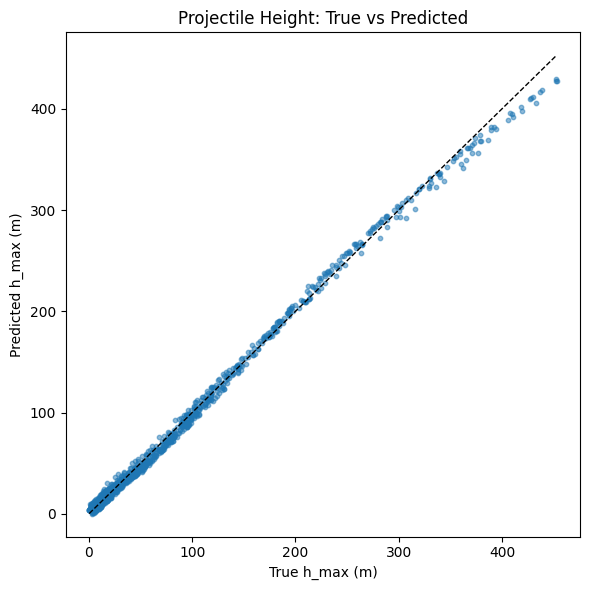

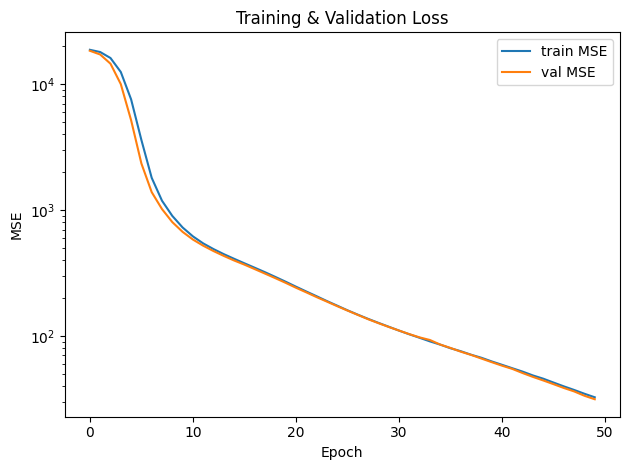

In [7]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


df = pd.read_csv("projectile_maxheight.csv")
X = df[["v_m_per_s", "theta_rad"]].values  # features
y = df["h_max_meters"].values              # target (shape (N,))

#  Train/Test Split
#    - 80% training, 20% testing
#    - random_state ensures reproducible splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature Scaling
#    - We standardize both inputs so the NN trains faster
x_scaler = StandardScaler().fit(X_train)
X_train_s = x_scaler.transform(X_train)
X_test_s  = x_scaler.transform(X_test)


model = Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(8,  activation="relu"),
    layers.Dense(1,  activation="linear"),  # linear for regression
])
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)
model.summary()


history = model.fit(
    X_train_s, y_train,
    validation_split=0.2,  # further hold-out 20% of train for val
    epochs=50,
    batch_size=32,
    verbose=2
)

# Evaluate on the Test Set
y_pred = model.predict(X_test_s).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"\nTest MSE : {mse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test R²  : {r2:.4f}")

#  Visualize True vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=10, alpha=0.5)
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlabel("True h_max (m)")
plt.ylabel("Predicted h_max (m)")
plt.title("Projectile Height: True vs Predicted")
plt.tight_layout()
plt.show()

# Plot Training History
plt.figure()
plt.plot(history.history["loss"], label="train MSE")
plt.plot(history.history["val_loss"], label="val MSE")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training & Validation Loss")
plt.tight_layout()
plt.show()
